In [75]:
using OnlineStats, GLM, DataFrames, Gadfly

# generate data with sparse coefficient vector
n, p = 2000, 10
x = randn(n, p)
β = vcat(1:p)  # β = [1,2,3,...,10]
y = -2.0 + x * β + randn(n);

# Set model hyperparameters

In [87]:
o1 = SGModel(p, algorithm = SGD(r = .5, η = 1.0))
o2 = SGModel(p, algorithm = Proxgrad(η = 1.0));

In [88]:
df1 = DataFrame(vcat(state(o1)...)')
df2 = DataFrame(vcat(state(o2)...)')
names!(df1, vcat([symbol("β$i") for i in 0:p]..., :nobs))
names!(df2, vcat([symbol("β$i") for i in 0:p]..., :nobs))
batchsize = 10
v1 = tracefit!(o1, batchsize, x, y)
v2 = tracefit!(o2, batchsize, x, y);
for i in 1:length(v1)
    push!(df1, vcat(state(v1[i])...)')
    push!(df2, vcat(state(v2[i])...)')
end
df1[:model] = :SGD
df2[:model] = :Adagrad;

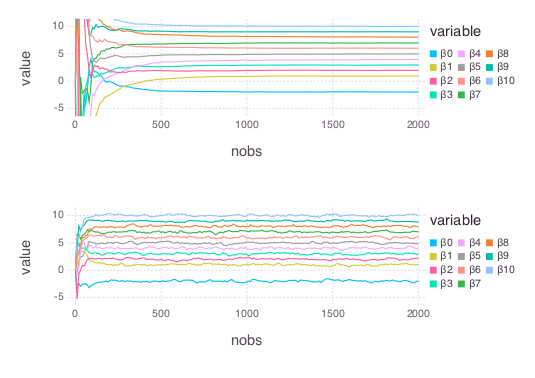

In [89]:
df1_melt = melt(df1, [:nobs, :model])
df2_melt = melt(df2, [:nobs, :model])

p1 = plot(df1_melt, x=:nobs, y=:value, color=:variable, Geom.line, Scale.y_continuous(minvalue = -3, maxvalue = 10))
p2 = plot(df2_melt, x=:nobs, y=:value, color=:variable, Geom.line, Scale.y_continuous(minvalue = -3, maxvalue = 10))
vstack(p1, p2)

In [90]:
function mse(x, y, β)
    sumabs2(y - x*β[2:end] - β[1]) / length(y)
end
mse(x, y, coef(o1))

df1 = DataFrame()
df2 = DataFrame()
df1[:nobs] = [nobs(vi) for vi in v1]
df2[:nobs] = [nobs(vi) for vi in v2]
df1[:model] = :SGD
df2[:model] = :Adagrad
mymse = mse(x, y, vcat(-2., β...))
df1[:mse] = [mse(x, y, coef(vi)) / mymse for vi in v1]
df2[:mse] = [mse(x, y, coef(vi)) / mymse for vi in v2]
df = vcat(df1, df2);

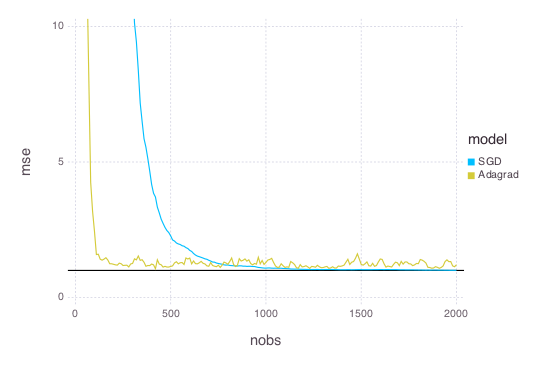

In [98]:
# loss of estimate relative to truth
p = plot(df, x=:nobs, y=:mse, color=:model, Geom.line,
yintercept = vcat(1.), Geom.hline(color=colorant"black"))
push!(p, Scale.y_continuous(minvalue = 0, maxvalue = 10))